<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

어떤 상태에서 특정한 액션을 취하면 리워드가 발생한다.
정책신경망에서 어떤 상태일때 액선이 산출되고 그 산출로 인한 리워드가 최대가 되도록 정책신경망의 가중치를 조정한다. 그러면 리워드가 최대가 되는 액션을 산출하는 정책신경망이 될 것이다. 

loss함수는 리워드가 최대가 되는 액션을 산출했을 때, 마이너스 무한대가 되도록 조정하면 된다. 

먼저 LSTM과 일반적 deep learning 모델을 비교해본 결과 fit 능력에서 차이는 없었다.

In [44]:
import numpy as np
import matplotlib.pyplot as plt

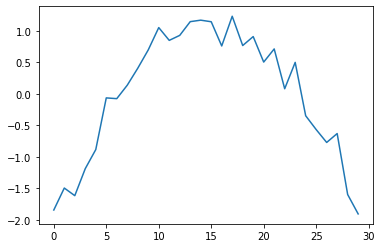

In [45]:
def env():
  price=[]
  for i in range(30):
    bias = np.random.rand(1)
    p = -0.01*(i-15)**2 + bias * 0.5
    price.append(p[0])
  p_mean = np.mean(price)
  p_std = np.std(price)
  price = (price - p_mean)/p_std
  
  p_serise= []
  for i in range(26):
    serise = [np.array(price[i]),np.array(price[i+1]), np.array(price[i+2]), np.array(price[i+3]), np.array(price[i+4])]
    serise = np.array(serise)
    p_serise.append(serise)
  p_serise= p_serise[0:25]
  p_serise = np.array(p_serise)
  #p_serise = p_serise.reshape(25, 5, 1)  # LSTM을 사용할 때 데이터 input 형태
  price_lstm = price[5:]
  price_lstm = np.array(price_lstm)
  return price, p_serise, price_lstm

price, p_serise, price_lstm = env()
plt.plot(price)
plt.show()

In [ ]:
p_serise[0][4]

-0.9429274328283418

In [ ]:
p_serise[1][4] - p_serise[0][0]

1.7276799128803768

In [ ]:
price_lstm

array([-0.26394863, -0.20099924,  0.01970195,  0.16678404,  0.32968015,
        0.84090406,  0.91281789,  0.71375709,  0.74797535,  1.3361712 ,
        1.1516485 ,  1.26868038,  1.2221345 ,  1.13824994,  0.88221452,
        1.03131344,  0.60012732,  0.293646  , -0.09904511, -0.15610572,
       -0.40339424, -0.56212655, -1.35607255, -1.62205066, -1.77331761])

1은 구매, 2는 홀딩, 3은 매각이다.

In [ ]:
price_lstm_y = np.array([1.0, 1.0,  1.0,  1.0, 1.0, 1.0,  1.0,  1.0,  1.0,  1.0, 0.0 ,  0.0,  0.0,  0.0,  2.0, 2.0,  2.0,  2.0,  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])

In [ ]:
len(price_lstm_y)

25

In [ ]:
from tensorflow.keras.utils import to_categorical
y_encoded = keras.utils.to_categorical(price_lstm_y, 3) # 분류 갯수를 정하기 위한 인수(3)가 필요하다.

In [ ]:
y_encoded[0]

array([0., 1., 0.], dtype=float32)

In [ ]:
def action(y_encoded):
  acts=[]
  for i in range(len(y_encoded)):
    act = np.argmax(y_encoded[i])
    acts.append(act)
  return acts

In [ ]:
print(action(y_encoded))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [ ]:
#inp_L = layers.Input(shape=(5,1),name="input_L")  # LSTM 용
#dense_L = LSTM(5, return_sequences=False)(inp_L)  # LSTM 용
inp_L = layers.Input(shape=(5,),name="input_L")
#dense_L = Dense(64)(dense_L)
dense_L = Dense(64)(inp_L)
#output_L = Dense(1)(dense_L)
output_s = layers.Dense(3, activation="softmax",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense_L)

model_lstm = Model(inputs=inp_L, outputs = output_s)

In [ ]:
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_L (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
out (Dense)                  (None, 3)                 192       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mae'])

In [ ]:
history_lstm = model_lstm.fit(p_serise, y_encoded, epochs=150, verbose=0)

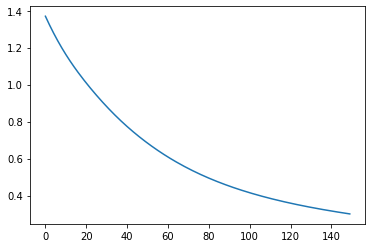

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.show()

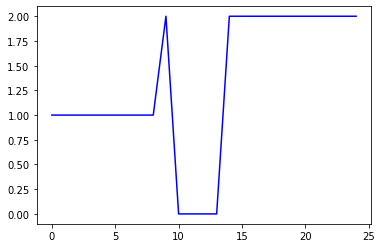

In [ ]:
plt.plot(action(model_lstm.predict(p_serise)), 'b')
# plt.plot(price_lstm_y, 'r')
plt.show()

In [ ]:
test = np.array([[-4.19567895, -2.90260542, -1.19901328, -0.66878054, -0.18498446],
[-0.19567895, -0.90260542, -1.19901328, -0.66878054, -0.18498446],
[-0.19567895, -0.90260542, -1.19901328, -2.66878054, -10.18498446],
])
a = model_lstm.predict(test)
print(action(a))

[1, 1, 2]


In [ ]:
# 랜덤하게 행동들을 만들어낸다. 사실 이건 필요하지 않다.

def act():
  actions = []
  for i in range(30):
    if np.random.rand() > 0.5:
      act = 1
    else:
      act = 0
    actions.append(act)
  return actions

In [ ]:
y = act()

In [ ]:
print(reward(price, y))

[0, -1, -2, -3, -2, -3, -2, -3, -2, -1, -2, -1, 0, 1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -2, -2, -2, -2, -2, -3]


여기서부터 정책경사

In [46]:
def reward_lstm (p_serise, action):
  rewards =[0]
  
  for i in range(len(p_serise)-1):
    price_gap = p_serise[i+1][4] - p_serise[i][0]
    if price_gap >= 0 and action[i] == 1 :
       reward = 1
       rewards.append(reward)
    if price_gap >= 0 and action[i] == 0 :
       reward = 0
       rewards.append(reward)
    if price_gap >= 0 and action[i] == 2 :
       reward = -1
       rewards.append(reward)
    if price_gap <= 0 and action[i] == 1 :
       reward = -1
       rewards.append(reward)
    if price_gap <= 0 and action[i] == 0 :
       reward = 0
       rewards.append(reward)
    if price_gap <= 0 and action[i] == 2 :
       reward = 1
       rewards.append(reward)

  return rewards


In [ ]:
len(reward_lstm (p_serise, price_lstm_y))

25

In [47]:
 def act_selection(act):
   acts = []
   for i in range(0, len(act)):
     action = np.random.choice(3,p=act[i])
     acts.append(action)
   return acts

In [48]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

In [ ]:
multip = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
len(multip)

25

In [49]:
def get_policy_model(lr):
  inp_L = layers.Input(shape=(5,),name="input_L")
  multip = layers.Input(shape=[1], name="advantages")
  dense_L = Dense(64)(inp_L)
  output_s = layers.Dense(3, activation="softmax",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense_L)

  model_train = Model(inputs=[inp_L, multip], outputs = output_s)

  # loss 함수를 actual과 predict가 같을때 -무한대가 되도록 만든다. 완전히 틀리면 0 이므로 loss 함수의 값의 범위는 -무한대 ~ 0 이다.
  def custom_loss(y_true, y_pred):
    # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf   log(0) = - inf
    # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf   
    # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0      log(1) = 0
    # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
    a = y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred)
    log_lik = K.log(a)
    return K.mean(log_lik * multip, keepdims=True)

  model_train.compile(loss=custom_loss, optimizer=Adam(lr), metrics = ['mae'])
  model_predict = Model(inputs=[inp_L], outputs = output_s)
  return model_train, model_predict

In [50]:
model_train, model_predict = get_policy_model(0.0001)

In [51]:
model_train.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_L (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
out (Dense)                  (None, 3)                 192       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Setting up our environment

num_actions = 3
num_episode = 0
num_episodes = 1000
dimen = 25

action_list = []
reward_list = []
reward_sum_list = []

price, p_serise, price_lstm = env()

while num_episode < num_episodes:

    losses = []
     
    p_serise = p_serise.astype(float) # nan 발생을 막기 위한 시도이다.

    for i in range(50):
      predict = model_predict.predict(p_serise)  # 한개의 state를 input해서 신경망을 통해 action을 만들어낸다.
      
      acts = []
      for i in range(0, len(predict)):
        action = np.random.choice(range(num_actions),p=predict[i]) # 대안 중에서 하나를 선택한다. p=[0.4, 0.6] 대안이 선택될 확율이다. action은 0 또는 1 이된다.
        acts.append(action)

      action_list.append(acts)

      e_r = reward_lstm(p_serise, acts)

      reward_sum_list.append(np.sum(e_r))
      reward_list.append(e_r)

    index = np.argmax(reward_sum_list)
    e_r = reward_list[index]
    acts = action_list[index]
      

      # 여기서 최고의 e_r을 보였던 acts을 찾아내고 그 것으로 훈련을 시켜야 하다.


    e_r = np.array(e_r)

    if np.sum(e_r) > 15.0:
      break
    else:
      y_encoded = keras.utils.to_categorical(acts, 3)
      loss = model_train.train_on_batch([p_serise, e_r/100], y_encoded)

    action_list = []
    reward_list = []
    reward_sum_list = []
        

    losses.append(loss)

    if (num_episode+1) % 100 == 0:
      print("num_episode: ",num_episode+1, "loss: ", losses[-1][0], "model_reward: ", np.sum(e_r))

    num_episode += 1
    price, p_serise, price_lstm = env()

num_episode:  100 loss:  0.0015838286 model_reward:  8
num_episode:  200 loss:  0.000733044 model_reward:  7
num_episode:  300 loss:  -0.0019277083 model_reward:  9
num_episode:  400 loss:  -0.00011221692 model_reward:  6
num_episode:  500 loss:  -0.0023620059 model_reward:  6
num_episode:  600 loss:  -0.0027669552 model_reward:  8
num_episode:  700 loss:  -0.004986869 model_reward:  8
num_episode:  800 loss:  -0.006285314 model_reward:  9
num_episode:  900 loss:  -0.006942893 model_reward:  7
num_episode:  1000 loss:  -0.0068660774 model_reward:  6


In [53]:
predict = model_predict.predict(p_serise)

In [54]:
action_c=[]

for i in range(len(predict)):
  a = np.argmax(predict[i])
  action_c.append(a)

In [55]:
np.sum(reward_lstm(p_serise, action_c))

3

In [56]:
action_c

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


만약 정책함수에서 softmax가 행동대안을 산출하면 각 행동대안이 갖는 확률을 기반으로 하여 새로운 행동을 산출한다. 만약 각 행동대안의 확율이 높아 질 수록 산출할 행동 대안의 모습은 수렴해 갈 것이다.

custom loss 함수를 테스트 해본다.

Using TensorFlow backend.


In [ ]:
def my_loss(y_true, y_pred):
  y_true = y_true **2
  y_pred = y_pred **2
  loss = K.mean(K.abs(y_true - y_pred) + K.square(y_true - y_pred))
  return loss * multip


# metric는 중요하지 않다.

def my_metric(y_true, y_pred):
  return K.mean(K.abs(y_true - y_pred)) * 1000

In [ ]:
# 하나의 에피소드 내에서 지연된 보상을 하기 위한 방법이다. 

def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    r = r[::-1]
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out)

In [ ]:
# test_set에 적용하는 함수

def score_model(model_predict, num_tests):
    scores = []    
    for num_test in range(num_tests):
        observation = env()
        forcasts = model_predict.predict(observation)
        rw = reward(observation, np.argmax(forcasts, axis=1))
        scores.append(rw)
    return np.mean(scores)